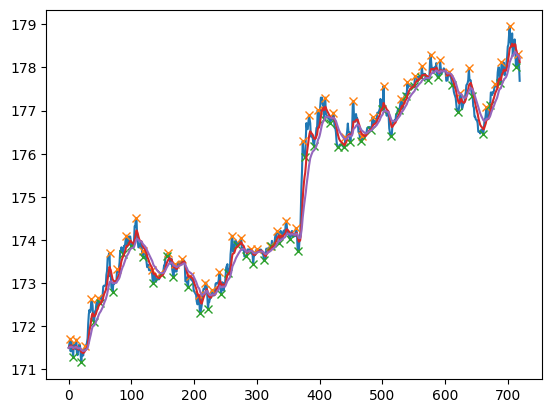

In [49]:
# use scipy to find the peaks and valleys of close price from kraken ohcl data
# find best ema crossover strategy for a given asset
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

# get data for the last 720 candles from kraken api
url = "https://api.kraken.com/0/public/OHLC"
querystring = {"pair":"SOLUSD","interval":"1"}
headers = {
  'Accept': 'application/json'
}
response = requests.request("GET", url, params=querystring)

# parse the json response and create a dataframe
data = response.json()
df = pd.DataFrame(data['result']['SOLUSD'], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

#besides time and count are strings so we need to convert them to floats
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['vwap'] = df['vwap'].astype(float)
df['volume'] = df['volume'].astype(float)
df['count'] = df['count'].astype(float)

# make a fast/slow ema crossover strategy
df['fast_ema'] = df['close'].ewm(span=9, adjust=False).mean()
df['slow_ema'] = df['close'].ewm(span=21, adjust=False).mean()
df['position'] = np.where(df['fast_ema'] > df['slow_ema'], 1, -1)
df['return'] = df['close'].pct_change()
df['strategy'] = df['position'].shift(1) * df['return']
df['creturns'] = df['return'].cumsum().apply(np.exp)
df['cstrategy'] = df['strategy'].cumsum().apply(np.exp)



# find the peaks and valleys of the close price
peaks, _ = find_peaks(df['close'], distance=10)
valleys, _ = find_peaks(-df['close'], distance=10)
plt.plot(df['close'])
plt.plot(peaks, df['close'][peaks], "x")
plt.plot(valleys, df['close'][valleys], "x")

# plot fast/slow ema crossover strategy
plt.plot(df['fast_ema'])
plt.plot(df['slow_ema'])

plt.show()





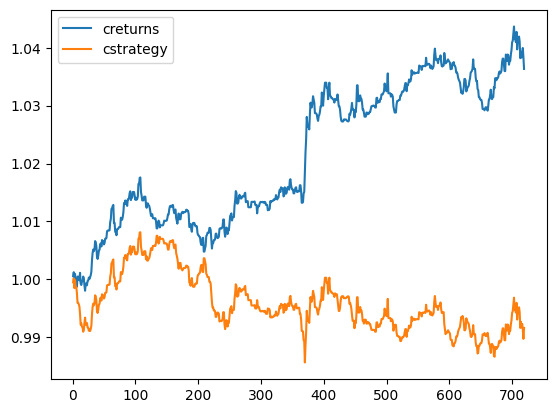

0.9916092889131779
1.0363399744912716
0.004857944432972321
0.012142178810529348


In [50]:
# plot the equity curve
df[['creturns', 'cstrategy']].plot()
plt.show()
print(df['cstrategy'].iloc[-1])
print(df['creturns'].iloc[-1])
print(df['cstrategy'].std())
print(df['creturns'].std())





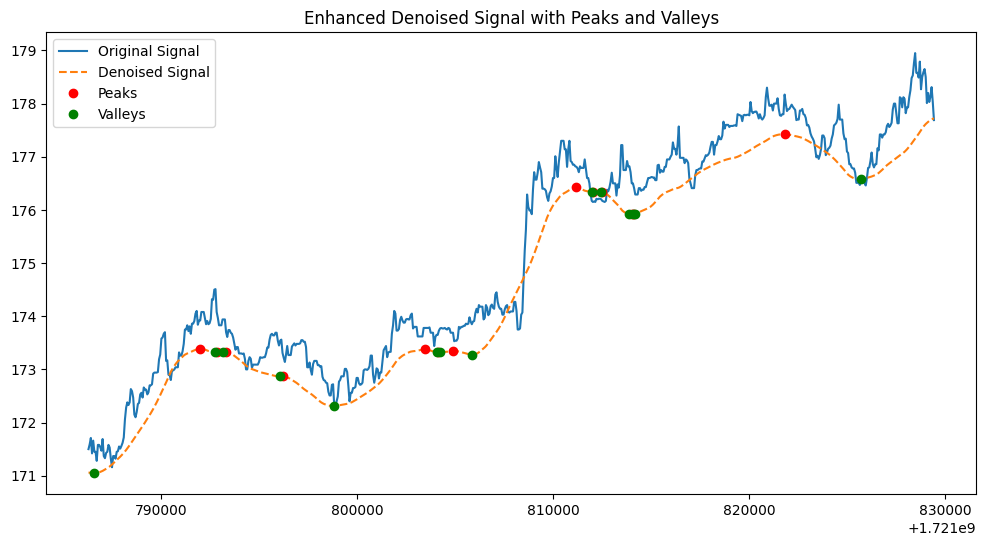

In [51]:
# if we want to find the peaks and valleys using the continuous wavelet transform
# we need to install pywavelets
import pywt
import numpy as np

# Extract the 'close' prices
close_prices = df['close'].values

# Perform wavelet decomposition
wavelet = 'db4'
max_level = pywt.dwt_max_level(len(close_prices), wavelet)
coeffs = pywt.wavedec(close_prices, wavelet, level=max_level)

# Apply thresholding to remove noise
threshold = np.sqrt(2 * np.log(len(close_prices)))
coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Reconstruct the denoised signal
denoised_signal = pywt.waverec(coeffs_thresholded, wavelet)

# Find peaks
peaks, _ = find_peaks(denoised_signal)
# Find valleys by inverting the signal
valleys, _ = find_peaks(-denoised_signal)

# Add denoised signal, peaks, and valleys to the dataframe
df['denoised_signal'] = denoised_signal
df['peaks'] = np.where(np.isin(range(len(df)), peaks), 1, 0)
df['valleys'] = np.where(np.isin(range(len(df)), valleys), 1, 0)


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['time'], close_prices, label='Original Signal')
plt.plot(df['time'], denoised_signal, label='Denoised Signal', linestyle='--')
plt.plot(df['time'][peaks], denoised_signal[peaks], 'ro', label='Peaks')
plt.plot(df['time'][valleys], denoised_signal[valleys], 'go', label='Valleys')
plt.legend()
plt.title('Enhanced Denoised Signal with Peaks and Valleys')
plt.show()



